In [81]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [82]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [83]:
# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)


# Parâmetros adicionais
n = 14
d = 15
e = 14
# Lista de parâmetros n para iterar
t_list = [3, 4, 5, 6 , 7, 8, 9 ,10, 11, 12, 13, 14, 15, 16 ]  # Exemplo de diferentes valores de n
alpha = 0.10  # Mantemos um único valor de alpha


price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


for t in t_list:
    # Criação das variáveis low_t e high_t
    low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
    # Cálculo dos valores mínimos e máximos baseados na janela t
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

    # Cálculo do k_percent
    k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

    # Armazenando os resultados no DataFrame com nomes dinâmicos
    price_data[f'low_{t}'] = low_t
    price_data[f'high_{t}'] = high_t
    price_data[f'k_percent_{t}'] = k_percent
    
    # Calculando o indicador
    r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
    price_data[f'r_percent_{t}'] = r_percent    

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()

price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,low_3,high_3,k_percent_3,r_percent_3,low_4,high_4,k_percent_4,r_percent_4,low_5,high_5,k_percent_5,r_percent_5,low_6,high_6,k_percent_6,r_percent_6,low_7,high_7,k_percent_7,r_percent_7,low_8,high_8,k_percent_8,r_percent_8,low_9,high_9,k_percent_9,r_percent_9,low_10,high_10,k_percent_10,r_percent_10,low_11,high_11,k_percent_11,r_percent_11,low_12,high_12,k_percent_12,r_percent_12,low_13,high_13,k_percent_13,r_percent_13,low_14,high_14,k_percent_14,r_percent_14,low_15,high_15,k_percent_15,r_percent_15,low_16,high_16,k_percent_16,r_percent_16,down_days,up_days,RSI,Smoothed_Close_1,Verify,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
11764,2024-12-27,54.730000,55.080002,54.459999,54.740002,54.740002,16635300,VALE3.SA,-0.269997,56.328998,-1.0,54.400002,55.400002,192.899665,92.899665,53.330002,55.400002,144.879072,44.879072,53.330002,55.400002,144.879072,44.879072,53.330002,55.869999,118.070857,18.070857,53.330002,56.400002,97.687187,-2.312813,53.330002,56.540001,93.426704,-6.573296,53.330002,56.709999,88.727775,-11.272225,53.330002,57.680000,68.942469,-31.057531,53.330002,59.590000,47.907303,-52.092697,53.330002,59.939999,45.370617,-54.629383,53.330002,60.189999,43.717168,-56.282832,53.330002,60.189999,43.717168,-56.282832,53.330002,60.189999,43.717168,-56.282832,53.330002,60.189999,43.717168,-56.282832,0.269997,0.0,36.806222,54.740002,-1.0,-0.038349,-0.856589,-0.716997,2598477848,54.020000
11765,2024-12-30,54.900002,55.189999,54.549999,54.549999,54.549999,11250900,VALE3.SA,-0.190002,56.151098,-1.0,54.400002,55.400002,175.109676,75.109676,54.400002,55.400002,175.109676,75.109676,53.330002,55.400002,136.284873,36.284873,53.330002,55.400002,136.284873,36.284873,53.330002,55.869999,111.066916,11.066916,53.330002,56.400002,91.892402,-8.107598,53.330002,56.540001,87.884650,-12.115350,53.330002,56.709999,83.464460,-16.535540,53.330002,57.680000,64.852815,-35.147185,53.330002,59.590000,45.065451,-54.934549,53.330002,59.939999,42.679241,-57.320759,53.330002,60.189999,41.123874,-58.876126,53.330002,60.189999,41.123874,-58.876126,53.330002,60.189999,41.123874,-58.876126,0.190002,0.0,35.242227,54.549999,-1.0,-0.038488,-0.890655,-0.751729,2587226948,52.660000
11766,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,55.960988,-1.0,54.230000,55.189999,180.311517,80.311517,54.230000,55.400002,147.947520,47.947520,54.230000,55.400002,147.947520,47.947520,53.330002,55.400002,127.100822,27.100822,53.330002,55.400002,127.100822,27.100822,53.330002,55.869999,103.582269,3.582269,53.330002,56.400002,85.699899,-14.300101,53.330002,56.540001,81.962224,-18.037776,53.330002,56.709999,77.839904,-22.160096,53.330002,57.680000,60.482472,-39.517528,53.330002,59.590000,42.028552,-57.971448,53.330002,59.939999,39.803145,-60.196855,53.330002,60.189999,38.352593,-61.647407,53.330002,60.189999,38.352593,-61.647407,0.299999,0.0,32.709994,54.250000,-1.0,-0.044086,-0.922360,-0.785855,2569603048,52.320000
11767,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,55.688890,-1.0,52.880001,55.189999,121.597042,21.597042,52.880001,55.189999,121.597042,21.597042,52.880001,55.400002,111.463817,11.463817,52.880001,55.400002,111.463817,11.463817,52.880001,55.400002,111.463817,11.463817,52.880001,55.400002,111.463817,11.463817,52.880001,55.869999,93.942833,-6.057167,52.880001,56.400002,79.797964,-20.202036,52.880001,56.540001,76.745596,-23.254404,52.880001,56.709999,73.339169,-26.660831,52.880001,57.680000,58.518524,-41.481476,52.880001,59.590000,41.861238,-58.138762,52.880001,59.939999,39.785973,-60.214027,52.880001,60.189999,38.425303,-61.574697,1.009998,0.0,25.572295,53.240002,-1.0,-0.050726,-0.958395,-0.820363,2545994348,53.029999
11768,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,55.376001,-1.0,52.480000,55.099998,110.534449,10.534449,52.480000,55.189

In [84]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,low_3,high_3,k_percent_3,r_percent_3,low_4,high_4,k_percent_4,r_percent_4,low_5,high_5,k_percent_5,r_percent_5,low_6,high_6,k_percent_6,r_percent_6,low_7,high_7,k_percent_7,r_percent_7,low_8,high_8,k_percent_8,r_percent_8,low_9,high_9,k_percent_9,r_percent_9,low_10,high_10,k_percent_10,r_percent_10,low_11,high_11,k_percent_11,r_percent_11,low_12,high_12,k_percent_12,r_percent_12,low_13,high_13,k_percent_13,r_percent_13,low_14,high_14,k_percent_14,r_percent_14,low_15,high_15,k_percent_15,r_percent_15,low_16,high_16,k_percent_16,r_percent_16,down_days,up_days,RSI,Smoothed_Close_1,Verify,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
5731,2024-12-27,12.16,12.19,11.97,12.07,12.07,37624000,ABEV3.SA,-0.070001,12.831797,-1.0,11.97,12.34,232.918171,132.918171,11.97,12.34,232.918171,132.918171,11.97,12.91,91.680569,-8.319431,11.97,13.08,77.639390,-22.360610,11.97,13.19,70.639135,-29.360865,11.97,13.42,59.434281,-40.565719,11.97,13.42,59.434281,-40.565719,11.97,13.58,53.527773,-46.472227,11.97,14.36,36.058460,-63.941540,11.97,14.50,34.063125,-65.936875,11.97,14.50,34.063125,-65.936875,11.97,14.53,33.663951,-66.336049,11.97,14.53,33.663951,-66.336049,11.97,14.53,33.663951,-66.336049,0.070001,0.0,24.226632,12.07,-1.0,-0.016972,0.043745,0.092703,-2870349193,11.25
5732,2024-12-30,12.06,12.16,11.74,11.74,11.74,38907400,ABEV3.SA,-0.330000,12.722617,-1.0,11.74,12.24,196.523543,96.523543,11.74,12.34,163.769515,63.769515,11.74,12.34,163.769515,63.769515,11.74,12.91,83.984415,-16.015585,11.74,13.08,73.329672,-26.670328,11.74,13.19,67.766748,-32.233252,11.74,13.42,58.489139,-41.510861,11.74,13.42,58.489139,-41.510861,11.74,13.58,53.403132,-46.596868,11.74,14.36,37.504495,-62.495505,11.74,14.50,35.602088,-64.397912,11.74,14.50,35.602088,-64.397912,11.74,14.53,35.219273,-64.780727,11.74,14.53,35.219273,-64.780727,0.330000,0.0,19.331009,11.74,-1.0,-0.033971,0.013040,0.076770,-2909256593,11.02
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,12.610356,-1.0,11.49,12.19,160.050902,60.050902,11.49,12.24,149.380801,49.380801,11.49,12.34,131.806530,31.806530,11.49,12.34,131.806530,31.806530,11.49,12.91,78.898306,-21.101694,11.49,13.08,70.462635,-29.537365,11.49,13.19,65.903302,-34.096698,11.49,13.42,58.049525,-41.950475,11.49,13.42,58.049525,-41.950475,11.49,13.58,53.605547,-46.394453,11.49,14.36,39.036796,-60.963204,11.49,14.50,37.221127,-62.778873,11.49,14.50,37.221127,-62.778873,11.49,14.53,36.853816,-63.146184,0.139999,0.0,17.590948,11.60,-1.0,-0.049996,-0.020121,0.057392,-2942674493,11.05
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,12.482320,-1.0,11.27,12.16,136.215794,36.215794,11.27,12.19,131.774010,31.774010,11.27,12.24,124.981504,24.981504,11.27,12.34,113.300942,13.300942,11.27,12.34,113.300942,13.300942,11.27,12.91,73.921963,-26.078037,11.27,13.08,66.979011,-33.020989,11.27,13.19,63.141682,-36.858318,11.27,13.42,56.386974,-43.613026,11.27,13.42,56.386974,-43.613026,11.27,13.58,52.481386,-47.518614,11.27,14.36,39.233659,-60.766341,11.27,14.50,37.533124,-62.466876,11.27,14.50,37.533124,-62.466876,0.270000,0.0,14.655374,11.33,-1.0,-0.066645,-0.056086,0.034696,-2984040393,10.87
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,12.363088,-1.0,11.21,11.89,169.571708,69.571708,11.21,12.16,121.377722,21.377722,11.21,12.19,117.662109,17.662109,11.21,12.24,111.950333,11.950333,11.21,12.34,102.043187,2.043187,11.21,12.34,102.043187,2.043187,11.21,12.91,67.828721,-32.171279,11.21,13.08,61.662471,-38.337529,11.21,13.19,58.236788,-41.763212,11.21,13.42,52.175933,-47.824067,11.21,13.42,52.175933,-47.824067,11.21,13.58,48.653510,-51.346490,11.21,14.36,36.605977,-63.394023,11.21,14.50,35.048272,-64.951728,0.040000,0.0,14.248904,11.29,-1.0,-0.078499,-0.093136,0.009130,-3034921893,10.91


t: 3
Fold 1:
 - Correct Prediction (y_test): 49.53%
 - Correct Prediction (Verify): 46.38%
Fold 2:
 - Correct Prediction (y_test): 57.19%
 - Correct Prediction (Verify): 46.80%
Fold 3:
 - Correct Prediction (y_test): 57.29%
 - Correct Prediction (Verify): 45.33%
Fold 4:
 - Correct Prediction (y_test): 64.43%
 - Correct Prediction (Verify): 61.49%
Fold 5:
 - Correct Prediction (y_test): 69.36%
 - Correct Prediction (Verify): 53.52%
Média de acurácia (y_test) para t 3: 59.56%
Média de acurácia (Verify) para t 3: 50.70%
---
t: 4
Fold 1:
 - Correct Prediction (y_test): 49.84%
 - Correct Prediction (Verify): 44.60%
Fold 2:
 - Correct Prediction (y_test): 57.29%
 - Correct Prediction (Verify): 45.65%
Fold 3:
 - Correct Prediction (y_test): 56.35%
 - Correct Prediction (Verify): 45.86%
Fold 4:
 - Correct Prediction (y_test): 64.32%
 - Correct Prediction (Verify): 60.34%
Fold 5:
 - Correct Prediction (y_test): 69.25%
 - Correct Prediction (Verify): 52.78%
Média de acurácia (y_test) para t 4: 5

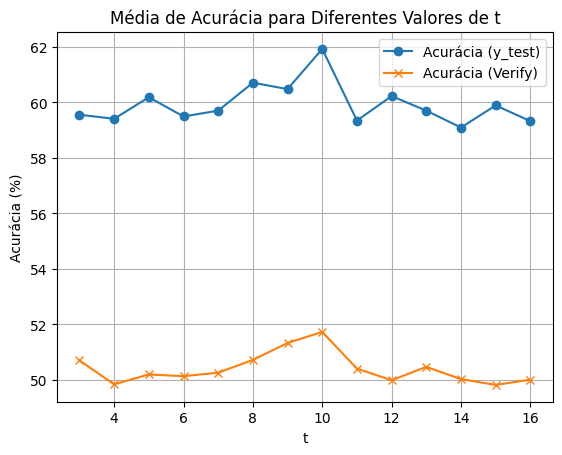

In [85]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por t
mean_accuracy_by_t = []

# Loop para cada t em t_list e realização de validação cruzada em série temporal
for t in t_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    # Converter para float32
    X = X.astype(np.float32)

    print(f't: {t}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por t
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_t.append((t, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para t {t}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para t {t}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for t, acc_ytest, acc_verify in mean_accuracy_by_t:
    print(f't: {t} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por t
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_t)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de t")
plt.xlabel('t')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)